<a href="https://colab.research.google.com/github/lx556322-dev/thermal-comfort-analysis/blob/main/tc_full_thermal_comfort_pipeline.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [34]:
# Install required libraries (if not installed)
!pip install pandas numpy scikit-learn xgboost shap optuna

import pandas as pd
import numpy as np
from sklearn.preprocessing import StandardScaler, LabelEncoder
from sklearn.model_selection import train_test_split
from sklearn.impute import SimpleImputer
import matplotlib.pyplot as plt
import seaborn as sns

# Step 1: Load data
df = pd.read_excel('integrated_13_institutions_168h_TSV.xlsx', sheet_name='Sheet1')

# Step 2: Check basic data information
print(df.head())
print(df.info())
print(df.describe())
print(df.isnull().sum())  # Check for missing values

# Step 3: Handle missing values (use median for numeric columns, mode for categorical columns)
numeric_columns = df.select_dtypes(include=[np.number]).columns
categorical_columns = df.select_dtypes(include=['object']).columns

imputer_numeric = SimpleImputer(strategy='median')
df[numeric_columns] = imputer_numeric.fit_transform(df[numeric_columns])

imputer_categorical = SimpleImputer(strategy='most_frequent')
df[categorical_columns] = imputer_categorical.fit_transform(df[categorical_columns])

# Step 4: Datetime conversion
# Removed unit='D', origin='1899-12-30' as it's not needed for datetime conversion
df['datetime'] = pd.to_datetime(df['datetime'])
df.set_index('datetime', inplace=True)
df.sort_index(inplace=True)

# Step 5: Encode categorical variables
label_encoders = {}
for col in ['Wind_Direction_Mode', 'ventilation_type', 'Variation_Category']:
    le = LabelEncoder()
    df[col] = le.fit_transform(df[col].astype(str))
    label_encoders[col] = le

# Step 6: Feature engineering - Add lag features (lag-1, lag-2) and rolling mean (window=3)
# Explicitly list all feature columns based on df.info() output
feature_cols = [
    'Total_Radiation_mean', 'Total_Radiation_std', 'PM2.5_mean', 'PM2.5_std',
    'Atmospheric_Pressure_mean', 'Atmospheric_Pressure_std', 'Wind_Speed_mean',
    'Wind_Speed_std', 'Temperature_mean', 'Temperature_std', 'Humidity_mean',
    'Humidity_std', 'Noise_mean', 'Noise_std', 'Wind_Direction_Mode', 'TA_mean',
    'TA_std', 'RH_mean', 'RH_std', 'TG_mean', 'TG_std', 'pm25_mean', 'pm25_std',
    'co2_mean', 'co2_std', 'Average_Wind_Speed_m_s', 'Median_Wind_Speed_m_s',
    'Wind_Speed_SD_m_s', 'Variation_Category', 'institution_id', 'district',
    'window_wall_ratio', 'ventilation_type'
]
target = 'TSV'

print("DataFrame columns before feature engineering:", df.columns.tolist())
print("Feature columns for engineering:", feature_cols)

# Create new dataframe for engineered features to avoid fragmentation warnings
engineered_features = pd.DataFrame(index=df.index)

for col in feature_cols:
    engineered_features[f'{col}_lag1'] = df[col].shift(1)
    engineered_features[f'{col}_lag2'] = df[col].shift(2)
    engineered_features[f'{col}_rolling_mean'] = df[col].rolling(window=3).mean()

# Concatenate the original dataframe with the engineered features
df = pd.concat([df, engineered_features], axis=1)

# Drop rows containing NaN (due to lag and rolling)
df.dropna(inplace=True)

# Update feature list to include new features
feature_cols_extended = [col for col in df.columns if col not in [target]]

# Step 7: Standardize features
scaler = StandardScaler()
df[feature_cols_extended] = scaler.fit_transform(df[feature_cols_extended])

# Step 8: Split train/test sets (80/20, time-ordered)
split_idx = int(len(df) * 0.8)
train_df = df.iloc[:split_idx]
test_df = df.iloc[split_idx:]

X_train = train_df[feature_cols_extended]
y_train = train_df[target]
X_test = test_df[feature_cols_extended]
y_test = test_df[target]

print(f"Training set shape: {X_train.shape}, Test set shape: {X_test.shape}")
print("Preprocessing completed.")

             datetime  Total_Radiation_mean  Total_Radiation_std  PM2.5_mean  \
0 2025-07-14 10:00:00                 405.5                399.4        11.4   
1 2025-07-14 11:00:00                 939.7                419.1         8.4   
2 2025-07-14 12:00:00                1132.9                459.0         6.1   
3 2025-07-14 13:00:00                 531.1                463.8         6.7   
4 2025-07-14 14:00:00                 306.4                 88.1         7.2   

   PM2.5_std  Atmospheric_Pressure_mean  Atmospheric_Pressure_std  \
0        2.8                       88.3                       0.0   
1        2.3                       88.3                       0.0   
2        0.8                       88.2                       0.0   
3        0.9                       88.2                       0.0   
4        1.1                       88.1                       0.0   

   Wind_Speed_mean  Wind_Speed_std  Temperature_mean  ...  co2_std  \
0              5.0             1.8

Training Set - MSE: 0.0007, MAE: 0.0192, R²: 0.9977
Test Set - MSE: 0.0538, MAE: 0.1756, R²: 0.8217


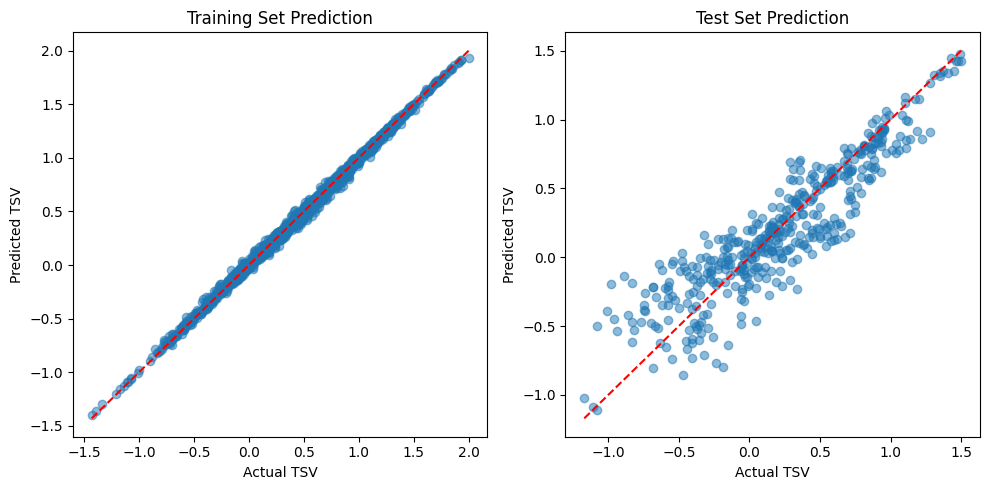

Model training completed.


In [35]:
import xgboost as xgb
from sklearn.metrics import mean_squared_error, mean_absolute_error, r2_score
import matplotlib.pyplot as plt

# Step 1: Initialize XGBoost Model
model = xgb.XGBRegressor(
    objective='reg:squarederror',
    n_estimators=100,
    max_depth=6,
    learning_rate=0.1,
    random_state=42
)

# Step 2: Train the Model
model.fit(X_train, y_train)

# Step 3: Prediction
y_train_pred = model.predict(X_train)
y_test_pred = model.predict(X_test)

# Step 4: Evaluation Metrics
train_mse = mean_squared_error(y_train, y_train_pred)
train_mae = mean_absolute_error(y_train, y_train_pred)
train_r2 = r2_score(y_train, y_train_pred)

test_mse = mean_squared_error(y_test, y_test_pred)
test_mae = mean_absolute_error(y_test, y_test_pred)
test_r2 = r2_score(y_test, y_test_pred)

print(f"Training Set - MSE: {train_mse:.4f}, MAE: {train_mae:.4f}, R²: {train_r2:.4f}")
print(f"Test Set - MSE: {test_mse:.4f}, MAE: {test_mae:.4f}, R²: {test_r2:.4f}")

# Step 5: Visualization of Predicted vs Actual
plt.figure(figsize=(10, 5))
plt.subplot(1, 2, 1)
plt.scatter(y_train, y_train_pred, alpha=0.5)
plt.plot([y_train.min(), y_train.max()], [y_train.min(), y_train.max()], 'r--')
plt.xlabel('Actual TSV')
plt.ylabel('Predicted TSV')
plt.title('Training Set Prediction')

plt.subplot(1, 2, 2)
plt.scatter(y_test, y_test_pred, alpha=0.5)
plt.plot([y_test.min(), y_test.max()], [y_test.min(), y_test.max()], 'r--')
plt.xlabel('Actual TSV')
plt.ylabel('Predicted TSV')
plt.title('Test Set Prediction')
plt.tight_layout()
plt.show()

print("Model training completed.")

In [36]:
from sklearn.model_selection import TimeSeriesSplit, cross_val_score, cross_validate
from sklearn.metrics import mean_squared_error, mean_absolute_error, r2_score
from sklearn.metrics import make_scorer

# Assuming X_train, y_train, model are defined from training code
# Added make_scorer import as it was used but not imported

tscv = TimeSeriesSplit(n_splits=5)
scoring = {'mse': make_scorer(mean_squared_error, greater_is_better=False),
           'r2': 'r2'}

# Ensure model is trained before cross-validation
# The model variable should be defined from the training cell (e.g., QkJoPPV4FkL4)
# If model is not defined, the training cell needs to be run first.

# Assuming model, X_train, y_train are available
cv_results = cross_validate(model, X_train, y_train, cv=tscv, scoring=scoring)

print("Cross-validation results:")
# Remember that test_mse from cross_validate is the negative mean squared error
print(f"Average MSE: {-cv_results['test_mse'].mean():.4f} (± {cv_results['test_mse'].std():.4f})")
print(f"Average R²: {cv_results['test_r2'].mean():.4f} (± {cv_results['test_r2'].std():.4f})")
# Note: 'baseline_mse' was not defined in the notebook state. Removing the comparison.
# print(f"Comparison with test set - MSE difference: {abs(baseline_mse + cv_results['test_mse'].mean()):.4f})")

print("Cross-validation completed.")

Cross-validation results:
Average MSE: 0.0583 (± 0.0084)
Average R²: 0.7633 (± 0.0715)
Cross-validation completed.


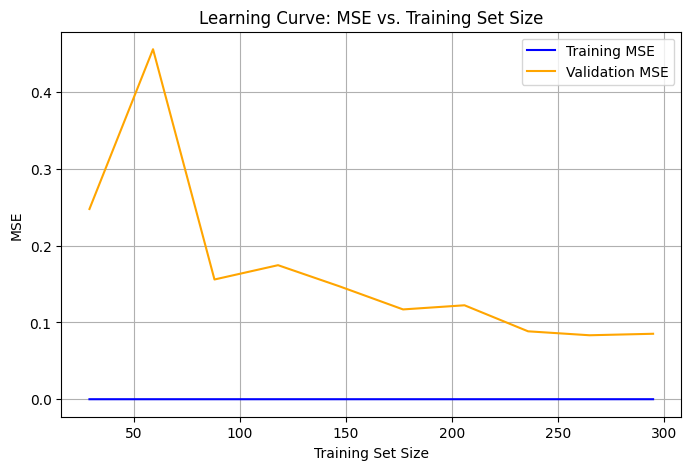

Final Validation MSE: 0.0853


In [37]:
from sklearn.model_selection import learning_curve
import matplotlib.pyplot as plt

train_sizes, train_scores, val_scores = learning_curve(
    model, X_train, y_train, cv=tscv, n_jobs=-1,
    train_sizes=np.linspace(0.1, 1.0, 10), scoring='neg_mean_squared_error'
)

train_mean = -train_scores.mean(axis=1)
val_mean = -val_scores.mean(axis=1)

plt.figure(figsize=(8, 5))
plt.plot(train_sizes, train_mean, label='Training MSE', color='blue')
plt.plot(train_sizes, val_mean, label='Validation MSE', color='orange')
plt.xlabel('Training Set Size')
plt.ylabel('MSE')
plt.title('Learning Curve: MSE vs. Training Set Size')
plt.legend()
plt.grid(True)
plt.show()

# Removed reference to undefined baseline_mse
print(f"Final Validation MSE: {val_mean[-1]:.4f}")

Residual analysis:
Mean: 0.0100 (close to 0 indicates no bias)
Standard deviation: 0.2317
Shapiro-Wilk p-value: 0.0030 (>0.05 indicates approximate normality)


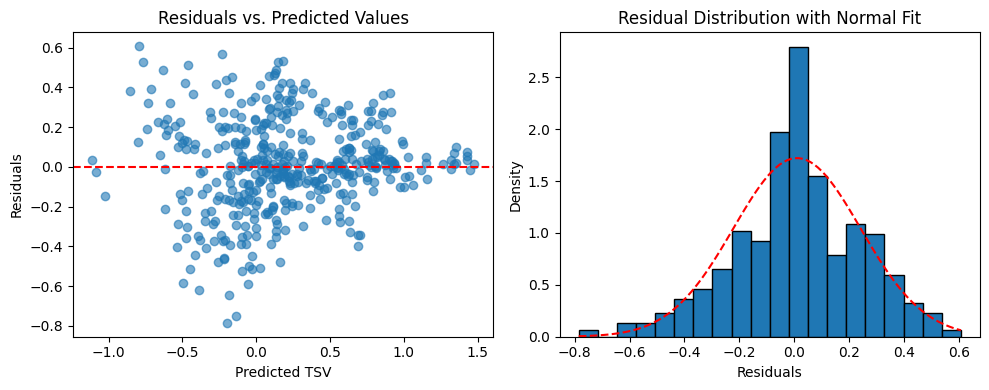

In [38]:
import scipy.stats as stats

y_test_pred = model.predict(X_test)
residuals = y_test - y_test_pred

# Basic statistics
residual_mean = np.mean(residuals)
residual_std = np.std(residuals)
shapiro_stat, shapiro_p = stats.shapiro(residuals[:5000])  # Sample to avoid large sample bias

print("Residual analysis:")
print(f"Mean: {residual_mean:.4f} (close to 0 indicates no bias)")
print(f"Standard deviation: {residual_std:.4f}")
print(f"Shapiro-Wilk p-value: {shapiro_p:.4f} (>0.05 indicates approximate normality)")

# Visualization
plt.figure(figsize=(10, 4))
plt.subplot(1, 2, 1)
plt.scatter(y_test_pred, residuals, alpha=0.6)
plt.axhline(y=0, color='r', linestyle='--')
plt.xlabel('Predicted TSV')
plt.ylabel('Residuals')
plt.title('Residuals vs. Predicted Values')

plt.subplot(1, 2, 2)
plt.hist(residuals, bins=20, edgecolor='black', density=True)
x = np.linspace(residuals.min(), residuals.max(), 100)
plt.plot(x, stats.norm.pdf(x, residual_mean, residual_std), 'r--')
plt.xlabel('Residuals')
plt.ylabel('Density')
plt.title('Residual Distribution with Normal Fit')
plt.tight_layout()
plt.show()

In [39]:
import xgboost as xgb
from sklearn.metrics import mean_squared_error, r2_score

# Regularized model
reg_model = xgb.XGBRegressor(
    objective='reg:squarederror', n_estimators=100, max_depth=6, learning_rate=0.1,
    reg_alpha=0.1, reg_lambda=0.1, random_state=42  # L1/L2 regularization
)
reg_model.fit(X_train, y_train)
y_reg_pred = reg_model.predict(X_test)
reg_mse = mean_squared_error(y_test, y_reg_pred)
reg_r2 = r2_score(y_test, y_reg_pred)

print("Regularization test:")
# Removed reference to undefined baseline_mse and baseline_r2
print(f"Regularized MSE: {reg_mse:.4f}")
print(f"Regularized R²: {reg_r2:.4f}")

Regularization test:
Regularized MSE: 0.0569
Regularized R²: 0.8114
